<a href="https://colab.research.google.com/github/flecue/vqgan-clip/blob/main/CLIP_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP Semantic segmentation by [neverix](https://github.com/neverix)

Using CLIP for masking images with random crop-based semantic segmentation. Part of [CLIP Semantic Segmentation](https://colab.research.google.com/drive/1kNZYKlGRkkW4SDoawnq1ZoH0jhnX_jlV).

# Setting up CLIP

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-yjox93_a
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-yjox93_a
     |████████████████████████████████| 71kB 3.9MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 12.8MB 37.9MB/s 
  Created wheel for clip: filename=clip-1.0-cp37-none-any.whl size=1368708 sha256=4e6b954b706db2a13aa40b66712c7af1a59bc92f983146e2251785020d773593
  Stored in directory: /tmp/pip-ephem-wheel-cache-4fwruynx/wheels/79/51/d7/69f91d37121befe21d9c52332e04f592e17d1cabc7319b3e09
  Created wheel for ftfy: filename=ftfy-6.0.1-cp37-none-any.whl size=41573 sha256=fd1d8daef46788a10786338bdcc4d344f42919cfdadc1e07b7e6adac9f867b13
  Stored in directory: /root/.cache/pip/wheels/ae/73/c7/9056e14b04919e5c262fe80b54133b1a88d73683d05d7ac65c
Successfully built clip ftfy
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  F

In [ ]:
!wget https://c.stocksy.com/a/r2v500/z9/1410925.jpg -O fetch.jpg

--2021-05-10 20:14:10--  https://c.stocksy.com/a/r2v500/z9/1410925.jpg
Resolving c.stocksy.com (c.stocksy.com)... 104.18.213.42, 104.18.212.42, 2606:4700::6812:d52a, ...
Connecting to c.stocksy.com (c.stocksy.com)|104.18.213.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 165602 (162K) [image/jpeg]
Saving to: ‘fetch.jpg’

fetch.jpg           100%[===================>] 161.72K  --.-KB/s    in 0.1s    

2021-05-10 20:14:11 (1.26 MB/s) - ‘fetch.jpg’ saved [165602/165602]



In [ ]:
import torch
try:
    import importlib
    importlib.reload(clip)
    importlib.reload(clip.model)
except NameError:
    pass
import clip
import clip.model
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
 
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(# "RN50" 
                              "ViT-B/32"
                              , device=device, jit=True#False
                              )
 
image = preprocess(Image.open("fetch.jpg")).unsqueeze(0).to(device)
text = clip.tokenize(["a person", "a dog", "a stick", "a cat", "grass"]).to(device)
 
with torch.no_grad():
#     image_features, (a, v, src, srce)
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
#     print(image_features.shape, text_features.shape, a.shape)
#     xs = a[0][1:][0]
#     print(v[[0][1:]])
#     print(src.shape)
#     print(srce.shape)
#     dots = srce[0]
#     dots = dots / dots.norm(dim=-1, keepdim=True)
#     print(dots.shape, text_features.shape)
#     result = torch.einsum("hwc,tc->thw", (dots, text_features)).cpu().numpy().astype(np.float32)
#     print(result.shape)
#     for t in result:
#         plt.imshow(t)
#         plt.show()
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.cpu().numpy()
print(probs)

100%|███████████████████████████████████████| 354M/354M [00:13<00:00, 27.2MiB/s]


[[20.62 23.64 22.42 18.36 21.28]]


# Random crop method

In [ ]:
text = clip.tokenize(["a person", "a dog", "a stick", "a cat", "grass"]).to(device)


In [ ]:
import random
random.seed(8)
n_crops = 256
torch.cuda.empty_cache()

source = Image.open("fetch.jpg")
labels = ["an image containing a dog", "an image containing grass", "an image containing a man's head", "an image containing a stick", "an image containing a hand", "an image containing a cat", "an image containing the sky"]
texts = clip.tokenize(labels).to(device)

crops = []
w_, h_ = 640, 640 #448, 448
for _ in range(n_crops):
    w, h = random.randint(w_//2, w_), random.randint(h_//2, h_)
    h = w
    x1, y1 = random.randint(0, source.width - w), random.randint(0, source.height - h)
#     print(x1)
    x2, y2 = x1 + w, y1 + h
#     print(x1, y1, x2, y2)
    box = x1, y1, x2, y2
#     x1, y1, x2, y2 = (random.randrange(0, x) for x in source.size * 2)
#     x1, x2 = sorted((x1, x2))
#     y1, y2 = sorted((y1, y2))
#     box = x1, y1, x2, y2
    crp = source.crop(box)
    crp = crp.resize((224, 224))
#     print(crp.size)
    crop = preprocess(crp).unsqueeze(0).to(device)
    crops.append((crop, box))

stacked = torch.cat([x[0] for x in crops], axis=0)
with torch.no_grad():
    model.eval()
    logits, *_ = model(stacked, texts)
    # logits -= logits.mean(axis=0)
    # logits /= logits.std(axis=0)
    # logits = logits.softmax(dim=-1)

an image containing a dog


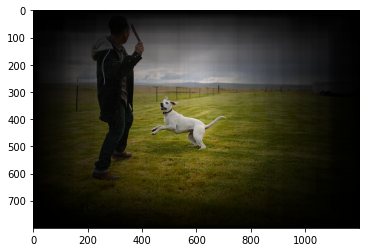

an image containing grass


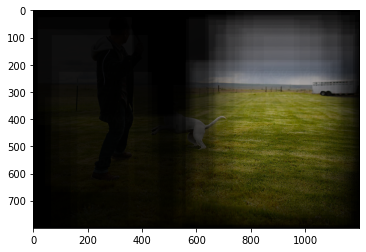

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


an image containing a man's head


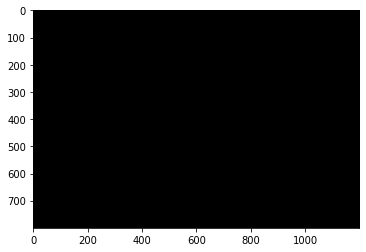

an image containing a stick


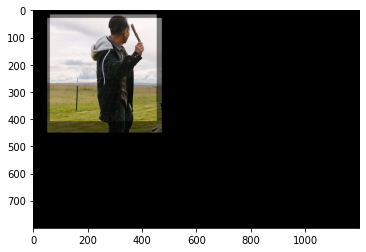

an image containing a hand


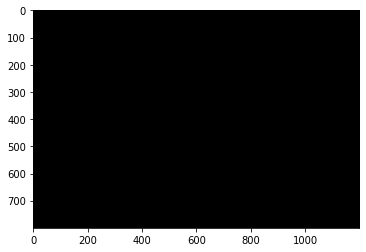

an image containing a cat


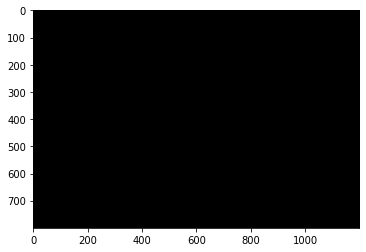

an image containing the sky


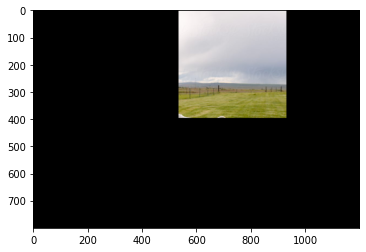

In [ ]:
if False:
    for (c, _), l in zip(crops, logits):
        print(l)
        plt.imshow(c.cpu()[0].transpose(0, -1))
        plt.show()

logs = (logits - logits.min()).exp()
# logs = logits
for i, t in enumerate(labels):
    img = np.zeros_like(np.array(source), dtype=np.float32)
    other = np.ones_like(np.array(source), dtype=np.float32)
    for x, (_, box) in zip(logs.softmax(dim=-1)
    , crops):
        # x = x.exp()
#         img[box[0]:box[2], box[1]:box[3]] += x.item()
        img[box[1]:box[3], box[0]:box[2]] += x[i].item()
        # other[box[1]:box[3], box[0]:box[2]] -= x[i].item()
        other[box[1]:box[3], box[0]:box[2]] += x.sum().item()
    # img /= other
    img -= img.min()
    img /= img.max()
#     img = img ** 4
    img *= np.array(source) / 256.
    
    print(t)
    plt.imshow(img)
    plt.show()